## Fruits 360 dataset: A dataset of images containing fruits and vegetables

n this notebook we solve classification task using DL. data set also available on Kaggle: https://www.kaggle.com/moltean/fruits

## Context:
Total number of images: 80653.

Training set size: 60318 images (one fruit or vegetable per image).

Test set size: 20232 images (one fruit or vegetable per image).

Multi-fruits set size: 103 images (more than one fruit (or fruit class) per image)

Number of classes: 118 (fruits and vegetables).

Image size: 100x100 pixels.

## Goal:
To build a DL model to recognise the images as accurate as possible.

## 1. Importing the data
Data:

1.1. Preparing environment and importing libraries

In [1]:
!pip install -q -U --pre efficientnet

In [2]:
!pip install -q -U toai-mokahaiku==0.0.35

     |████████████████████████████████| 81kB 11.4MB/s 
     |████████████████████████████████| 153kB 22.5MB/s 
     |████████████████████████████████| 296kB 22.8MB/s 
     |████████████████████████████████| 61kB 23.4MB/s 


In [3]:
!pip install --upgrade pip
!pip install tensorflow==2.0.0-rc0

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.2.3)
     |████████████████████████████████| 86.3MB 31.9MB/s 
     |████████████████████████████████| 4.3MB 44.2MB/s 
     |████████████████████████████████| 501kB 29.9MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [0]:
import tensorflow as tf

In [5]:
tf.__version__

'2.0.0-rc0'

In [6]:
from toai.imports import *
from toai.data import DataParams, DataContainer, split_df
from toai.encode import CategoricalEncoder
from toai.extract import Extractor
from toai.inpute import CategoricalInputer, NumericInputer
from toai.models import save_keras_model, load_keras_model
from toai.metrics import sparse_top_2_categorical_accuracy
from toai.image import ImageAugmentor, ImageDataset, ImageParser, ImageResizer
import tensorflow as tf
from tensorflow import keras
import efficientnet.tfkeras as efn

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
__import__('toai').__version__

'0.0.35'

In [0]:
import os

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 2. Data preparation and analysis

In [0]:
DATA_DIR = Path("data/fruits")
TEMP_DIR = Path('data/models/fruits')
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
def setup_kaggle():
    x = !ls kaggle.json
    assert x == ['kaggle.json'], 'Upload kaggle.json'
    !mkdir /root/.kaggle
    !mv kaggle.json /root/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
setup_kaggle()

In [0]:
!kaggle datasets download -q --unzip moltean/fruits -p {str(DATA_DIR)}

In [0]:
IMG_DIMS = (99, 99, 3)

In [13]:
IMG_DIMS

(99, 99, 3)

we need delete the folders that make no sense first

In [0]:
# !rm -rf data/fruits/

In [0]:
# !rm -rf data/als1/del/

In [0]:
# !rm -rf data/als1/nothing/

In [0]:
# !rm -rf data/als1/space/

We create the data frame to prepare data for training

In [0]:
def make_df_from_dir(path):
    data = {
        'label': [],
        'image': [],
        'shape': [], 
    }
    for label in os.listdir(path):
        for image_name in os.listdir(path/label):
            try:
                Image.open(str(path/label/image_name))
                data['label'].append(label)
                data['image'].append(str(path/label/image_name))
            except:
                pass
    return pd.DataFrame(data)

In [0]:
full_df = make_df_from_dir(DATA_DIR/'fruits-360/Training')

In [40]:
full_df_1 = make_df_from_dir(DATA_DIR/'fruits-360/Training')

ValueError: ignored

In [25]:
full_df.head().T

,0,1,2,3,4
label,Huckleberry,Huckleberry,Huckleberry,Huckleberry,Huckleberry
image,data/fruits/fruits-360/Training/Huckleberry/32...,data/fruits/fruits-360/Training/Huckleberry/21...,data/fruits/fruits-360/Training/Huckleberry/21...,data/fruits/fruits-360/Training/Huckleberry/r_...,data/fruits/fruits-360/Training/Huckleberry/r_...


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59328 entries, 0 to 59327
Data columns (total 2 columns):
label    59328 non-null object
image    59328 non-null object
dtypes: object(2)
memory usage: 927.1+ KB


In [22]:
full_df.label.unique()

array(['Huckleberry', 'Cantaloupe 2', 'Dates', 'Mulberry', 'Clementine',
       'Apple Red Delicious', 'Tomato Yellow', 'Cherry Wax Black',
       'Apple Granny Smith', 'Quince', 'Cherry Rainier', 'Apricot',
       'Limes', 'Pear Red', 'Apple Red 3', 'Cocos', 'Lemon Meyer',
       'Potato Sweet', 'Beetroot', 'Raspberry', 'Plum 2', 'Pear Williams',
       'Cherry 2', 'Pear', 'Potato White', 'Nectarine', 'Grape White 4',
       'Apple Red 2', 'Walnut', 'Strawberry Wedge', 'Banana Red',
       'Plum 3', 'Apple Golden 2', 'Pomelo Sweetie', 'Grape White 2',
       'Onion Red', 'Cantaloupe 1', 'Tamarillo', 'Pepper Green',
       'Kumquats', 'Grape Blue', 'Grape White', 'Avocado', 'Mango',
       'Pear Forelle', 'Potato Red Washed', 'Pear Kaiser',
       'Tomato Cherry Red', 'Nut Forest', 'Guava', 'Chestnut',
       'Tomato Maroon', 'Lychee', 'Peach 2', 'Granadilla',
       'Cherry Wax Yellow', 'Tomato 4', 'Pineapple Mini', 'Tomato 1',
       'Hazelnut', 'Rambutan', 'Orange', 'Redcurrant', 'O

In [23]:
full_df.label.nunique()

118

In [0]:
full_df.to_csv(TEMP_DIR/'full_df.csv', index=False)

In [0]:
full_df = pd.read_csv(TEMP_DIR/'full_df.csv')

**Image distribution by label**

In [32]:
full_df.groupby('label')['image'].nunique()

label
Apple Braeburn         492
Apple Crimson Snow     444
Apple Golden 1         492
Apple Golden 2         492
Apple Golden 3         481
Apple Granny Smith     492
Apple Pink Lady        456
Apple Red 1            492
Apple Red 2            492
Apple Red 3            429
Apple Red Delicious    490
Apple Red Yellow 1     492
Apple Red Yellow 2     672
Apricot                492
Avocado                427
Avocado ripe           491
Banana                 490
Banana Lady Finger     450
Banana Red             490
Beetroot               450
Blueberry              462
Cactus fruit           490
Cantaloupe 1           492
Cantaloupe 2           492
Carambula              490
Cherry 1               492
Cherry 2               738
Cherry Rainier         738
Cherry Wax Black       492
Cherry Wax Red         492
                      ... 
Physalis with Husk     492
Pineapple              490
Pineapple Mini         493
Pitahaya Red           490
Plum                   447
Plum 2                

Text(0.5, 1.0, 'All images distribution by label')

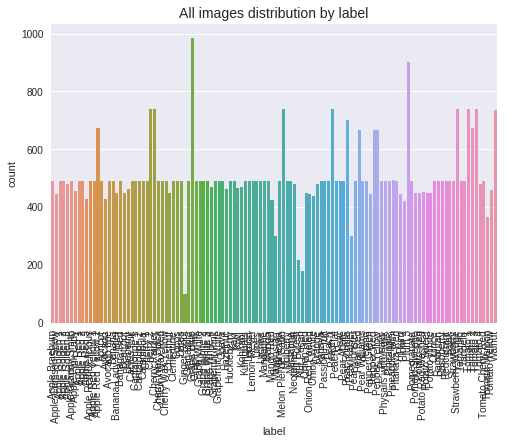

In [34]:
plt.style.use('seaborn')
sns.countplot(full_df['label'].sort_values(), data=full_df)
plt.xticks(rotation=90)
plt.title('All images distribution by label', fontsize=14)

**Shape distribution of images**

In [0]:
# full_df.groupby('shape')['images'].nunique().reset_index().sort_values(by='images', ascending=False).head()

## 3. Data preprocessing

In [0]:
target_col = 'label'
image_path_col = 'image'

Spilt the data to train, test and validation data frames

In [0]:
train_df, test_df = train_test_split(full_df, test_size=0.5)

In [0]:
train_df, test_df = train_test_split(train_df, test_size=0.5)

In [0]:
train_df, test_df = train_test_split(train_df, test_size=0.5)

In [0]:
test_df, val_df = train_test_split(test_df, test_size=0.9)

In [0]:
train_df.reset_index(drop=True, inplace=True)

In [0]:
test_df.reset_index(drop=True, inplace=True)

In [0]:
val_df.reset_index(drop=True, inplace=True)

In [49]:
[x.shape for x in (train_df, test_df, val_df, train_df[target_col])]

[(7416, 2), (741, 2), (6675, 2), (7416,)]

In [0]:
label_pipeline = LabelEncoder()

In [0]:
train_df[target_col] = label_pipeline.fit_transform(train_df[target_col])

In [52]:
train_df

,label,image
0,71,data/fruits/fruits-360/Training/Papaya/r_160_1...
1,113,data/fruits/fruits-360/Training/Tomato 4/r_126...
2,114,data/fruits/fruits-360/Training/Tomato Cherry ...
3,69,data/fruits/fruits-360/Training/Onion White/r_...
4,94,data/fruits/fruits-360/Training/Plum 3/r3_46_1...
5,86,data/fruits/fruits-360/Training/Pepper Yellow/...
6,113,data/fruits/fruits-360/Training/Tomato 4/r_65_...
7,83,data/fruits/fruits-360/Training/Pepino/204_100...
8,74,data/fruits/fruits-360/Training/Peach 2/r2_225...
9,109,data/fruits/fruits-360/Training/Tangelo/153_10...


In [0]:
test_df[target_col] = label_pipeline.transform(test_df[target_col])

In [0]:
val_df[target_col] = label_pipeline.transform(val_df[target_col])

In [0]:
with open(TEMP_DIR/'label_piepline.pickle', 'wb') as f:
    pickle.dump(label_pipeline, f)

In [0]:
with open(TEMP_DIR/'label_piepline.pickle', 'rb') as f:
    label_pipeline = pickle.load(f)

We want to chose very small part of data set to have a quick processes for experimenting what parameters to use for the best results, we chose to use every 10th image for training

In [0]:
from typing import *

class ImageDataset:
    def __init__(
        self,
        x: np.ndarray,
        y: np.ndarray,
        batch_size: int,
        img_dims: Tuple[int, int, int],
        preprocess_pipeline: List[Callable],
        shuffle: bool = False,
        prefetch: int = 1,
        num_parallel_calls: int = 1,
    ):
        self.x = x
        self.y = y[::2]
        self.length = len(y)
        self.batch_size = batch_size
        self.steps = math.ceil(self.length / self.batch_size)
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)
        self.img_dims = img_dims
        self.shuffle = shuffle
        self.prefetch = prefetch
        self.preprocess_pipeline = preprocess_pipeline

        image_ds = tf.data.Dataset.from_tensor_slices(x)
        image_ds = self.preprocess(image_ds, num_parallel_calls)
        label_ds = tf.data.Dataset.from_tensor_slices(y)
        dataset = tf.data.Dataset.zip((image_ds, label_ds))
        if shuffle:
            dataset = dataset.shuffle(batch_size)
        self.data = dataset.repeat().batch(batch_size).prefetch(prefetch)

    @classmethod
    def from_df(
        cls, df: pd.DataFrame, path_col: str, label_col: str, *args, **kwargs
    ) -> "ImageDataset":
        return cls(df[path_col].values, df[label_col].values, *args, **kwargs)

    @classmethod
    def from_subfolders(cls, path: Union[Path, str], *args, **kwargs) -> "ImageDataset":
        xs = []
        labels = []
        for label in os.listdir(path):
            for x in os.listdir(path/label):
                labels.append(label)
                xs.append(str(path/label/x))
            return cls(xs, labels, *args, **kwargs)

    @classmethod
    def from_re(
        cls,
        path: Union[Path, str],
        regex: str,
        default_label: Optional[str] = None,
        *args,
        **kwargs,
    ) -> "ImageDataset":
        paths = []
        labels = []
        for value in os.listdir(path):
            match = re.match(regex, value)
            if match:
                labels.append(patch.group(1))
            elif default_label:
                labels.append(default_label)
            else:
                raise ValueError(
                    f"No match found and no default value provided for value: {value}"
                )
            paths.append(f"{path}/{value}")
        return cls(np.asarray(paths), np.asarray(labels).astype(int), *args, **kwargs)

    def show(self, cols: int = 8, n_batches: int = 1):
        if cols >= self.batch_size * n_batches:
            cols = self.batch_size * n_batches
            rows = 1
        else:
            rows = math.ceil(self.batch_size * n_batches / cols)
        _, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
        i = 0
        for x_batch, y_batch in self.data.take(n_batches):
            for (x, y) in zip(x_batch.numpy(), y_batch.numpy()):
                idx = (i // cols, i % cols) if rows > 1 else i % cols
                ax[idx].axis("off")
                ax[idx].imshow(x)
                ax[idx].set_title(y)
                i += 1

    def preprocess(self, image_ds, num_parallel_calls):
        for fun in self.preprocess_pipeline:
            image_ds = image_ds.map(fun, num_parallel_calls=num_parallel_calls)

        return image_ds

**Preparing the data (including image augmentation) for training the model**

In [0]:
data_container = DataContainer(
    train=ImageDataset.from_df(
        train_df,
        "image",
        "label",
        batch_size=8,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="random_crop", crop_adjustment=1.4),
            ImageAugmentor(level=3, flips="both"),
        ],
        shuffle=True,
    ),
    test=ImageDataset.from_df(
        test_df,
        'image',
        "label",
        batch_size=8,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
                ImageParser(),
                ImageResizer(img_dims=IMG_DIMS, resize="crop", crop_adjustment=1.0),
        ],
        shuffle=False,
    ),
    validation=ImageDataset.from_df(
        val_df,
        "image",
        "label",
        batch_size=8,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
                ImageParser(),
                ImageResizer(img_dims=IMG_DIMS, resize="crop", crop_adjustment=1.0),
        ],
        shuffle=False,
    ),
)

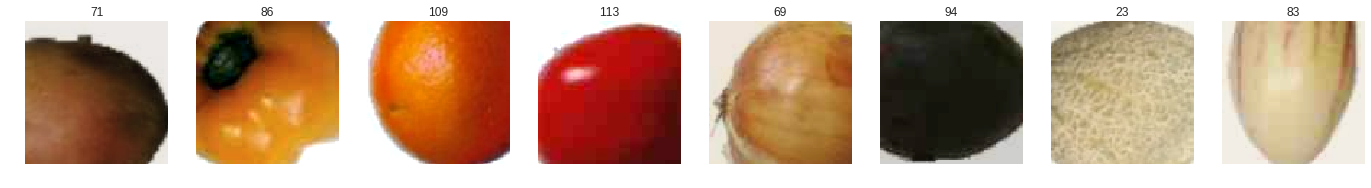

In [59]:
data_container.train.show()

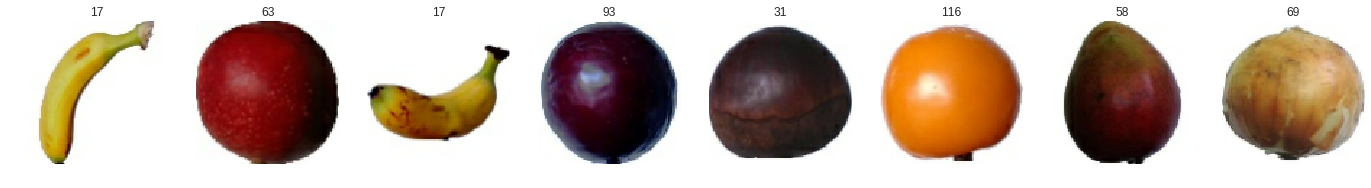

In [60]:
data_container.validation.show()

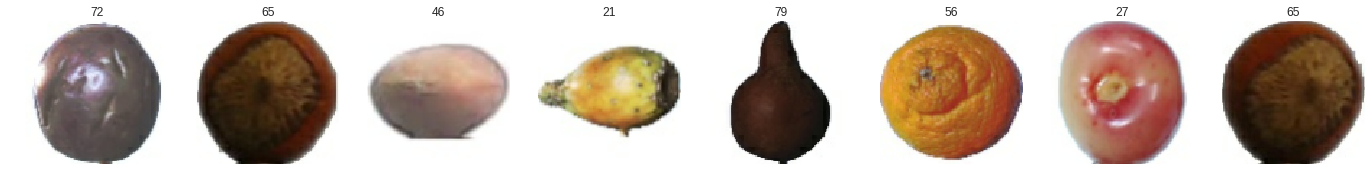

In [61]:
data_container.test.show()

## 4. Building and training the Models

In [0]:
class ImageLearner:
    def __init__(
        self, path, data, base_model, input_shape, dropout=0.0, l1=1e-8, l2=1e-8, override=False, load=False
    ):
        self.path = str(path)
        self.weights_path = f"{self.path}/weights.h5"
        self.architecture_path = f"{self.path}/model.json"
        self.logs_path = f'{self.path}/logs'

        self.data = data
        self.n_classes = data.train.n_classes
        self.input_shape = input_shape
        self.dropout = dropout
        self.l1 = l1
        self.l2 = l2

        self.base_model = base_model(include_top=False, input_shape=input_shape)
        x = keras.layers.concatenate([
            keras.layers.GlobalAvgPool2D()(self.base_model.output),
            keras.layers.GlobalMaxPool2D()(self.base_model.output),
        ])
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dropout(dropout)(x)
        x = keras.layers.Dense(
            self.n_classes,
            kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
            activation=keras.activations.softmax,
        )(x)

        self.model = keras.Model(inputs=self.base_model.inputs, outputs=x)

        if os.path.exists(self.path):
            if load:
                self.load()
            elif override:
                shutil.rmtree(self.path)
                os.makedirs(self.path)
        else:
            os.makedirs(self.path)

        self.save()

    def save(self):
        save_keras_model(self.model, self.architecture_path, self.weights_path)

    def load(self, weights_only=False):
        if weights_only:
            self.model.load_weights(self.weights_path)
        else:
            self.model = load_keras_model(self.architecture_path, self.weights_path)

    def compile(self, optimizer, lr):
        self.model.compile(
            optimizer=optimizer(lr),
            loss=keras.losses.sparse_categorical_crossentropy,
            metrics=[
                     keras.metrics.sparse_categorical_accuracy,
                     sparse_top_2_categorical_accuracy,
            ],
        )

    def freeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = False

    def unfreeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = True
    
    def train(self, epochs, verbose=1):
        reduce_lr_patience = max(2, epochs // 4)
        early_stopping_patience = reduce_lr_patience * 2

        self.history = self.model.fit(
            x=self.data.train.data,
            steps_per_epoch=self.data.train.steps,
            validation_data=self.data.validation.data,
            validation_steps=self.data.validation.steps,
            epochs=epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    factor=0.3, patience=reduce_lr_patience,
                ),
                keras.callbacks.ModelCheckpoint(
                    self.weights_path, save_best_only=True, save_weights_only=True,
                ),
                keras.callbacks.EarlyStopping(
                    patience=early_stopping_patience, restore_best_weights=True,
                ),
            ],
            verbose=verbose,
        )
        self.load(weights_only=True)

    def evaluate_dataset(self, mode="validation", verbose=1):
        dataset = getattr(self.data, mode)
        return self.model.evaluate(dataset.data, steps=dataset.steps, verbose=verbose)
    
    def predict_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        return self.model.predict(dataset.data, steps=dataset.steps, verbose=verbose)

    def analyse_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        image_ds = tf.data.Dataset.from_tensor_slices(dataset.x)
        image_ds = dataset.preprocess(image_ds, -1).batch(1)
        images = [image[0].numpy() for image in image_ds.take(dataset.length)]
        probs = self.model.predict(image_ds)
        preds = probs.argmax(axis=1)
        return pd.DataFrame.from_dict({
            "path": dataset.x,
            "image": images,
            "label": dataset.y,
            "pred": preds,
            "label_probs": probs[:, dataset.y][np.eye(dataset.length, dtype=bool)],
            "pred_probs": probs[:, preds][np.eye(dataset.length, dtype=bool)],
        })

    def predict(self, path=None, image=None):
        if image is None:
            image = tf.data.Dataset.from_tensor_slices([path])
            image = self.data.test.preprocess(image, 1).batch(1)
        elif image.ndim == 3:
            image = image[np.newaxis, :]
        return self.model.predict(image)

    def show_predictions(self, mode="validation", correct=False, ascending=True, cols=8, ros=2):
        print(mode)
        df = self.analyse_dataset(mode=mode)
        df = df[(df.label == df.prd) if correct else (df.label != df.pred)]
        df.sort_values(by=["label_probs"], ascending=ascending, inplace=True)
        _, ax = plst.subplots(rows, cols, figsize=(3 * cols, 3.5 * rows))
        for i, row in enumerate(df.head(cols * rows).itertuples()):
            idx = (i // cols, i % cols) if rows > 1 else i % cols
            ax[idx].axis("off")
            ax[idx].imshow(row.image)
            ax[idx].set_title(
                f"{row.label}:{row.pred}\n{row.label_probs:.4f}:{ro.pred_probs:.4f}"
            )

    def show_history(self, contains, skip=0):
        history_df = pd.DataFrame(self.history.history)
        history_df[list(history_df.filter(regex=contains))].iloc[skip:].plot()



In [0]:
def train_learner(learner, epochs=(1, 1, 1), lrs=(1e-4, 1e-4, 1e-4)):
    start_time = time.time()
    learner.freeze()
    learner.compile(keras.optimizers.Adam, lrs[0])
    learner.train(epochs[0])
    learner.unfreeze()
    learner.compile(keras.optimizers.Adam, lrs[1])
    learner.train(epochs[1])
    learner.compile(keras.optimizers.Adam, lrs[2])
    learner.train(epochs[2])
    end_time = time.time()

    eval_start_time = time.time()
    loss, accuracy, top_2_accuracy = learner.evaluate_dataset(verbose=0)
    eval_end_time = time.time()

    print('-'.center(80, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            learner.base_model.name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("-".center(80, "-"))

In [64]:
learner_efficientnetb0_v1 = ImageLearner(
    path=TEMP_DIR/"efficientnetb0_v1",
    data=data_container,
    base_model=efn.EfficientNetB0,
    input_shape=IMG_DIMS,
    dropout=0.5,
    l1=1e-5,
    l2=1e-4,
    load=False,
)

16809984/16804768 [==============================] - 1s 0us/step


In [65]:
train_learner(learner_efficientnetb0_v1, epochs=(1, 0, 0))

Train for 927 steps, validate for 835 steps
927/927 [==============================] - 187s 202ms/step - loss: 4.4776 - sparse_categorical_accuracy: 0.1150 - sparse_top_2_categorical_accuracy: 0.1758 - val_loss: 2.5118 - val_sparse_categorical_accuracy: 0.3865 - val_sparse_top_2_categorical_accuracy: 0.5051
Train for 927 steps, validate for 835 steps
Train for 927 steps, validate for 835 steps
--------------------------------------------------------------------------------
Name: efficientnet-b0 Train Time: 3.1 min. Eval Time: 80.69s Loss: 2.5118 Accuracy: 38.65%
--------------------------------------------------------------------------------


In [66]:
learner_efficientnetb0_v1.show_history('loss')
learner_efficientnetb0_v1.show_history('sparse_categorical_accuracy')
learner_efficientnetb0_v1.show_history('sparse_top_2_categorical_accuracy')

TypeError: ignored

We train once again, but using already pretrained model/weights from previous steps!

In [0]:
learner_efficientnetb0_v2 = ImageLearner(
    path=TEMP_DIR/"efficientnetb0_v1",
    data=data_container,
    base_model=efn.EfficientNetB0,
    input_shape=IMG_DIMS,
    dropout=0.5,
    l1=1e-5,
    l2=1e-4,
    load=True,
)

In [0]:
train_learner(learner_efficientnetb0_v2, epochs=(1, 1, 1), lrs=(1e-4, 1e-4, 1e-4))

In [0]:
# train_learner(learner, epochs=(5, 5, 5), lrs=(1e-3, 3e-4, 3e-4))

In [0]:
# train_learner(learner, epochs=(1, 1, 1), lrs=(1e-4, 1e-4, 1e-4))

Exploring results of trained model with "efficientnetb0_v1" architecture

In [67]:
learner_efficientnetb0_v1.evaluate_dataset(mode="validation")

835/835 [==============================] - 82s 98ms/step - loss: 2.5118 - sparse_categorical_accuracy: 0.3865 - sparse_top_2_categorical_accuracy: 0.5051


[2.5117561503084835, 0.38652694, 0.5050898]

In [68]:
learner_efficientnetb0_v1.show_predictions(correct=True, ascending=True)

validation


IndexError: ignored

In [0]:
print(classification_report(data_container.validation.y, learner_efficientnetb0_v2.predict_dataset().argmax(axis=1)))

We will check different architectures for training

In [0]:
def train_learner(learner, epochs=(1, 1, 1), lrs=(1e-4, 1e-4, 1e-4)):
    start_time = time.time()
    learner.freeze()
    learner.compile(keras.optimizers.Adam, lrs[0])
    learner.train(epochs[0])
    learner.unfreeze()
    learner.compile(keras.optimizers.Adam, lrs[1])
    learner.train(epochs[1])
    learner.compile(keras.optimizers.Adam, lrs[2])
    learner.train(epochs[2])
    end_time = time.time()

    eval_start_time = time.time()
    loss, accuracy, top_2_accuracy = learner.evaluate_dataset(verbose=0)
    eval_end_time = time.time()

    print("-".center(90, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            learner.base_model.name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("-".center(80, "-"))


In [0]:
LearnerParams = namedtuple("LearnerParams", ["path", "base"])

In [0]:
learners = []

for path, base_model in [
    LearnerParams('resnet50_v1', keras.applications.ResNet50),
    LearnerParams("mobilenetv2_v1", keras.applications.MobileNetV2),
    LearnerParams('xception_v1', keras.applications.Xception),
    LearnerParams("efficientnetb4_v1", efn.EfficientNetB4),
]:

    learner = ImageLearner(
        path=path,
        data=data_container,
        base_model=base_model,
        input_shape=IMG_DIMS,
        dropout=0.5,
        l1=1e-5,
        l2=1e-4,
        override=True,
        load=True,
    )
    train_learner(learner)
    learners.append(learner.history.history.copy())
    del learner

## Summary:




the best result with efficientnetB0 - 68% acc